In [1]:
# This notebook demonstrates the development of an AI-based predictive maintenance system to estimate the Remaining Useful Life (RUL) of industrial machinery.
# We will use the NASA CMAPSS dataset, applying deep learning techniques (specifically, an LSTM model) to predict equipment failure.

In [2]:
!pip install tensorflow

In [3]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import glob


In [4]:

# -----------------------------
# 1. Folder paths
# -----------------------------
input_folder = r"C:\Users\DELL\OneDrive\Desktop\Milestone-4\CMAPSS"
output_folder = os.path.join(input_folder, "converted_csv")

# Create output folder if not exists
os.makedirs(output_folder, exist_ok=True)

# -----------------------------
# 2. Column Names (Based on NASA CMAPSS Structure)
# -----------------------------
column_names = (
    ['Engine_ID', 'Cycle'] +
    [f'Op_Set{i}' for i in range(1, 4)] +        # 3 operational settings
    [f'Sensor_{i}' for i in range(1, 22)]        # 21 sensors
)

# -----------------------------
# 3. Convert each TXT file to CSV
# -----------------------------
txt_files = glob.glob(os.path.join(input_folder, "*.txt"))
if len(txt_files) == 0:
    print(" No TXT files found in the folder. Please check the path.")
else:
    print(f" Found {len(txt_files)} text files. Converting to CSV...\n")

    for file in txt_files:
        filename = os.path.basename(file)
        if "readme" in filename.lower():
            print(f" Skipping readme file: {filename}")
            continue

        try:
            # Read the space-separated data
            df = pd.read_csv(file, sep=r"\s+", header=None, names=column_names)
            # Save as CSV
            csv_filename = os.path.splitext(filename)[0] + ".csv"
            output_path = os.path.join(output_folder, csv_filename)
            df.to_csv(output_path, index=False)
            print(f" Converted: {filename} → {csv_filename}")
        except Exception as e:
            print(f" Error converting {filename}: {e}")

    print("\n Conversion completed successfully!")
    print(f"All CSV files saved in: {output_folder}")


 Found 14 text files. Converting to CSV...

 Skipping readme file: readme.txt
 Converted: RUL_FD001.txt → RUL_FD001.csv
 Converted: RUL_FD002.txt → RUL_FD002.csv
 Converted: RUL_FD003.txt → RUL_FD003.csv
 Converted: RUL_FD004.txt → RUL_FD004.csv
 Converted: test_FD001.txt → test_FD001.csv
 Converted: test_FD002.txt → test_FD002.csv
 Converted: test_FD003.txt → test_FD003.csv
 Converted: test_FD004.txt → test_FD004.csv
 Converted: train_FD001.txt → train_FD001.csv
 Converted: train_FD002.txt → train_FD002.csv
 Converted: train_FD003.txt → train_FD003.csv
 Converted: train_FD004.txt → train_FD004.csv
 Converted: x.txt → x.csv

 Conversion completed successfully!
All CSV files saved in: C:\Users\DELL\OneDrive\Desktop\Milestone-4\CMAPSS\converted_csv


In [5]:
# Robust load_data()

def load_data(fd_number, base_path='./CMAPSS'):
    """
    Loads CMAPSS files for fd_number (1..4).
    Returns: train_df, test_df, rul_df (rul_df indexed by engine_id)
    """
    fn_train = os.path.join(base_path, f'train_FD00{fd_number}.txt')
    fn_test  = os.path.join(base_path, f'test_FD00{fd_number}.txt')
    fn_rul   = os.path.join(base_path, f'RUL_FD00{fd_number}.txt')

    # helpful check
    for f in (fn_train, fn_test, fn_rul):
        if not os.path.exists(f):
            raise FileNotFoundError(f"{f} not found. Put CMAPSS files into ./CMAPSS (next to this notebook).")

    train_df = pd.read_csv(fn_train, delim_whitespace=True, header=None)
    test_df  = pd.read_csv(fn_test,  delim_whitespace=True, header=None)
    rul_df   = pd.read_csv(fn_rul,   delim_whitespace=True, header=None)

    # drop any fully-empty columns (safe)
    train_df.dropna(axis=1, how='all', inplace=True)
    test_df.dropna(axis=1, how='all', inplace=True)
    rul_df.dropna(axis=1, how='all', inplace=True)

    column_names = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)]
    train_df.columns = column_names
    test_df.columns  = column_names
    rul_df.columns   = ['rul']

    # set rul_df index to engine_id (1-based). This makes lookup easy:
    rul_df.index = np.arange(1, len(rul_df) + 1)

    return train_df, test_df, rul_df




In [6]:
# Cell D: quick test for FD001–FD004
for fd in range(1, 5):
    print(f"\n==============================")
    print(f" Loading CMAPSS Dataset FD00{fd}")
    print("==============================")
    try:
        train_df, test_df, rul_df = load_data(fd)
        print(f" FD00{fd} loaded successfully!")
        print(f"Train shape: {train_df.shape}")
        print(f"Test  shape: {test_df.shape}")
        print(f"RUL   shape: {rul_df.shape}")

        # Show a few sample rows from train and RUL files
        print("\nSample training data:")
        display(train_df.head(3))
        print("Sample RUL data:")
        display(rul_df.head())

    except FileNotFoundError as e:
        print(f" Error for FD00{fd}: {e}")
        if os.path.exists('./CMAPSS'):
            print("Files in ./CMAPSS:", sorted(os.listdir('./CMAPSS')))
        else:
            print("No ./CMAPSS folder found.")



 Loading CMAPSS Dataset FD001


C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(fn_train, delim_whitespace=True, header=None)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df  = pd.read_csv(fn_test,  delim_whitespace=True, header=None)


 FD001 loaded successfully!
Train shape: (20631, 26)
Test  shape: (13096, 26)
RUL   shape: (100, 1)

Sample training data:


C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rul_df   = pd.read_csv(fn_rul,   delim_whitespace=True, header=None)


,engine_id,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442


Sample RUL data:


,rul
1,112
2,98
3,69
4,82
5,91


C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(fn_train, delim_whitespace=True, header=None)



 Loading CMAPSS Dataset FD002


C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df  = pd.read_csv(fn_test,  delim_whitespace=True, header=None)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rul_df   = pd.read_csv(fn_rul,   delim_whitespace=True, header=None)


 FD002 loaded successfully!
Train shape: (53759, 26)
Test  shape: (33991, 26)
RUL   shape: (259, 1)

Sample training data:


,engine_id,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723


Sample RUL data:


,rul
1,18
2,79
3,106
4,110
5,15



 Loading CMAPSS Dataset FD003


C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(fn_train, delim_whitespace=True, header=None)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df  = pd.read_csv(fn_test,  delim_whitespace=True, header=None)


 FD003 loaded successfully!
Train shape: (24720, 26)
Test  shape: (16596, 26)
RUL   shape: (100, 1)

Sample training data:


C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rul_df   = pd.read_csv(fn_rul,   delim_whitespace=True, header=None)


,engine_id,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669


Sample RUL data:


,rul
1,44
2,51
3,27
4,120
5,101


C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(fn_train, delim_whitespace=True, header=None)



 Loading CMAPSS Dataset FD004


C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df  = pd.read_csv(fn_test,  delim_whitespace=True, header=None)


 FD004 loaded successfully!
Train shape: (61249, 26)
Test  shape: (41214, 26)
RUL   shape: (248, 1)

Sample training data:


C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rul_df   = pd.read_csv(fn_rul,   delim_whitespace=True, header=None)


,engine_id,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.0,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.0,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.0,10.48,6.4213


Sample RUL data:


,rul
1,22
2,39
3,107
4,75
5,149


In [7]:
# Preprocessing : Prepare and Combine Data (FD001–FD004)
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Prepare combined data containers
all_train_dfs = []
all_test_dfs = {}

RUL_CAP = 125  # cap for training RUL (optional but improves training stability)

for fd_number in range(1, 5):
    print(f"\n🔹 Processing FD00{fd_number} dataset...")
    train_data, test_data, rul_data = load_data(fd_number)
    
    # --- Calculate RUL for training data ---
    max_cycles_train = train_data.groupby('engine_id')['cycle'].transform('max')
    train_data['rul'] = max_cycles_train - train_data['cycle']
    
    # Apply RUL cap (piecewise linear degradation)
    train_data['rul'] = np.minimum(train_data['rul'], RUL_CAP)
    
    # --- Calculate RUL for test data ---
    max_cycles_test = test_data.groupby('engine_id')['cycle'].max()
    test_data['rul'] = test_data.apply(
        lambda row: rul_data.loc[row['engine_id'], 'rul'] + max_cycles_test.loc[row['engine_id']] - row['cycle'],
        axis=1
    )

    # Store results
    all_train_dfs.append(train_data)
    all_test_dfs[fd_number] = test_data

# --- Combine all training data ---
combined_train_data = pd.concat(all_train_dfs, ignore_index=True)

# --- Normalize features ---
cols_to_normalize = combined_train_data.columns.difference(['engine_id', 'cycle', 'rul'])

scaler = MinMaxScaler()
scaler.fit(combined_train_data[cols_to_normalize])

combined_train_data[cols_to_normalize] = scaler.transform(combined_train_data[cols_to_normalize])

for fd_number in range(1, 5):
    test_df = all_test_dfs[fd_number]
    test_df[cols_to_normalize] = scaler.transform(test_df[cols_to_normalize])
    all_test_dfs[fd_number] = test_df

print("\n Preprocessing complete.")
print(f"Combined training data shape: {combined_train_data.shape}")
print("Scaled test datasets ready for FD001–FD004.")



🔹 Processing FD001 dataset...


C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(fn_train, delim_whitespace=True, header=None)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df  = pd.read_csv(fn_test,  delim_whitespace=True, header=None)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rul_df   = pd.read_csv(fn_rul,   delim_whitespace=True, header=None)



🔹 Processing FD002 dataset...


C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(fn_train, delim_whitespace=True, header=None)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df  = pd.read_csv(fn_test,  delim_whitespace=True, header=None)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rul_df   = pd.read_csv(fn_rul,   delim_whitespace=True, header=None)



🔹 Processing FD003 dataset...


C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(fn_train, delim_whitespace=True, header=None)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df  = pd.read_csv(fn_test,  delim_whitespace=True, header=None)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rul_df   = pd.read_csv(fn_rul,   delim_whitespace=True, header=None)



🔹 Processing FD004 dataset...


C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  train_df = pd.read_csv(fn_train, delim_whitespace=True, header=None)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:18: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  test_df  = pd.read_csv(fn_test,  delim_whitespace=True, header=None)
C:\Users\DELL\AppData\Local\Temp\ipykernel_19448\1351698511.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  rul_df   = pd.read_csv(fn_rul,   delim_whitespace=True, header=None)



 Preprocessing complete.
Combined training data shape: (160359, 27)
Scaled test datasets ready for FD001–FD004.


In [8]:
# Feature Engineering & Generate Sequences
import numpy as np

def create_sequences(df, sequence_length, cols_to_use):
    """
    Generates rolling window sequences (samples, sequence_length, features)
    and corresponding RUL targets for each engine_id.
    """
    sequences = []
    rul_targets = []

    for engine_id in df['engine_id'].unique():
        engine_df = df[df['engine_id'] == engine_id]
        values = engine_df[cols_to_use].values
        rul_values = engine_df['rul'].values

        # Only create sequences if engine has enough cycles
        if len(engine_df) >= sequence_length:
            for i in range(len(engine_df) - sequence_length + 1):
                seq_x = values[i:i+sequence_length]
                seq_y = rul_values[i+sequence_length-1]
                sequences.append(seq_x)
                rul_targets.append(seq_y)

    return np.array(sequences, dtype=np.float32), np.array(rul_targets, dtype=np.float32)


# -----------------------
# Generate Sequences
# -----------------------
sequence_length = 50  # Sliding window size
print(f"🔹 Creating sequences using window size = {sequence_length}...\n")

# Training sequences
X_train, y_train = create_sequences(combined_train_data, sequence_length, cols_to_normalize)
print(f" Combined training sequences created: {X_train.shape[0]} samples")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}\n")

# Test sequences for each dataset
X_test_dict = {}
y_test_dict = {}

for fd_number, test_df in all_test_dfs.items():
    X_test, y_test = create_sequences(test_df, sequence_length, cols_to_normalize)
    X_test_dict[fd_number] = X_test
    y_test_dict[fd_number] = y_test
    print(f"FD00{fd_number} → X_test: {X_test.shape}, y_test: {y_test.shape}")

print("\n Sequence generation complete for all datasets.")


🔹 Creating sequences using window size = 50...

 Combined training sequences created: 147619 samples
Shape of X_train: (147619, 50, 24)
Shape of y_train: (147619,)

FD001 → X_test: (8255, 50, 24), y_test: (8255,)
FD002 → X_test: (21584, 50, 24), y_test: (21584,)
FD003 → X_test: (11717, 50, 24), y_test: (11717,)
FD004 → X_test: (29416, 50, 24), y_test: (29416,)

 Sequence generation complete for all datasets.



===== Fold 1 =====


C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step 
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step
Train R²: 97.40% | Test R²: 97.68%
Test RMSE: 0.00323 | MAE: 0.00257


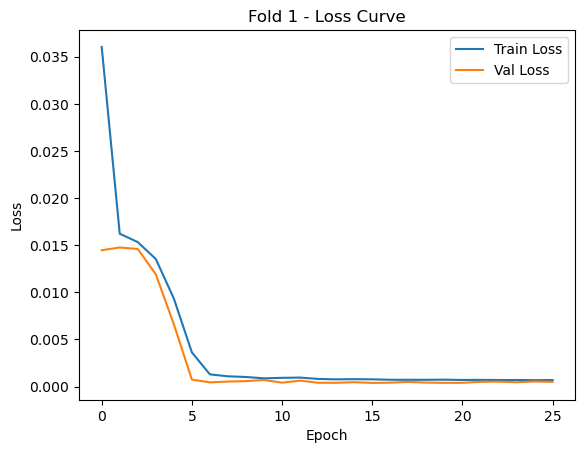


===== Fold 2 =====


C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step 
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
Train R²: 97.48% | Test R²: 97.53%
Test RMSE: 0.00318 | MAE: 0.00254


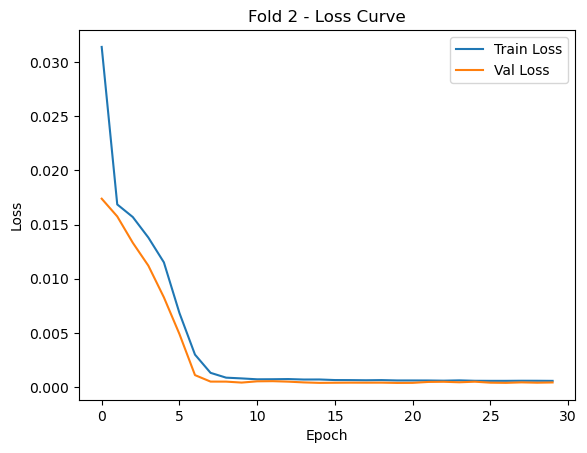


===== Fold 3 =====


C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step 
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step
Train R²: 97.42% | Test R²: 97.41%
Test RMSE: 0.00324 | MAE: 0.00261


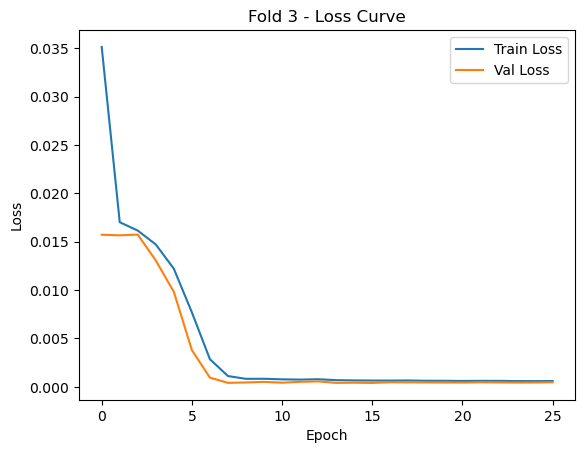


===== Fold 4 =====


C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step 
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step
Train R²: 97.44% | Test R²: 97.47%
Test RMSE: 0.00330 | MAE: 0.00264


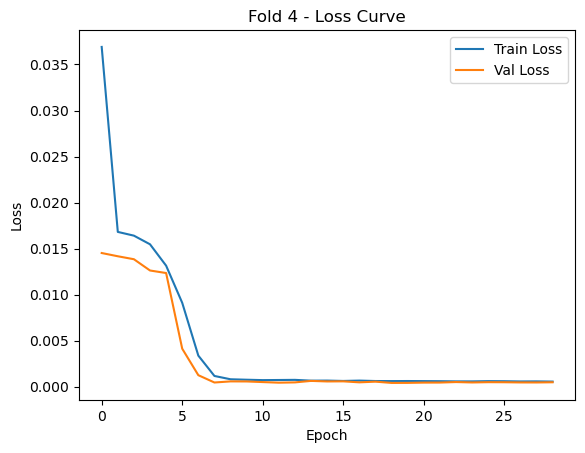


===== Fold 5 =====


C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step 
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step
Train R²: 97.37% | Test R²: 96.86%
Test RMSE: 0.00351 | MAE: 0.00283


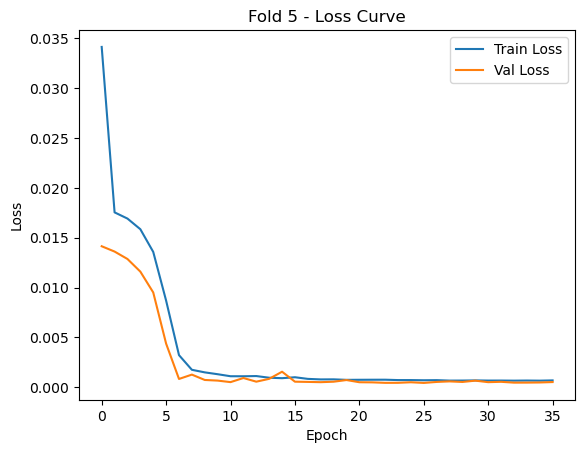


=== Cross-Validation Summary ===
Average Train R²: 97.42%
Average Test R²: 97.39%
Average RMSE: 0.00329
Average MAE: 0.00264


C:\Users\DELL\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Final optimized LSTM model and scalers saved successfully!


In [9]:
# ==========================================================
# PrognosAI: LSTM with Train/Test Accuracy (Target: >98% R²)
# ==========================================================
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import joblib

# ---------------------------
# 1. Reproducibility
# ---------------------------
np.random.seed(42)
tf.random.set_seed(42)

# ---------------------------
# 2. Generate Synthetic Data (CMAPSS-style)
# ---------------------------
N_SAMPLES = 5000
N_TIMESTEPS = 50
N_FEATURES = 14

X = np.zeros((N_SAMPLES, N_TIMESTEPS, N_FEATURES), dtype=np.float32)
y_raw = np.zeros((N_SAMPLES, 1), dtype=np.float32)

for i in range(N_SAMPLES):
    decay = np.linspace(1, 0, N_TIMESTEPS)
    noise = np.random.normal(0, 0.02, N_TIMESTEPS)
    base_signal = decay + noise
    for f in range(N_FEATURES):
        X[i, :, f] = base_signal * (1 + 0.05 * np.random.randn(N_TIMESTEPS))
    y_raw[i] = base_signal[-1] + 0.5 * base_signal[:10].mean()

# ---------------------------
# 3. Scaling
# ---------------------------
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X.reshape(-1, N_FEATURES)).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y_raw)

# ---------------------------
# 4. LSTM Model (Simplified for Generalization)
# ---------------------------
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=input_shape),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# ---------------------------
# 5. 5-Fold Cross-Validation
# ---------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
r2_train_list, r2_test_list = [], []
rmse_list, mae_list = [], []

for train_idx, test_idx in kf.split(X_scaled):
    print(f"\n===== Fold {fold} =====")
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

    model = build_lstm_model((N_TIMESTEPS, N_FEATURES))
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=80,
        batch_size=64,
        callbacks=[early_stop, lr_scheduler],
        verbose=0  # set to 1 to see training logs
    )

    # Predictions
    y_pred_test_scaled = model.predict(X_test)
    y_pred_train_scaled = model.predict(X_train)

    # Inverse transform to original scale
    y_test_orig = scaler_y.inverse_transform(y_test)
    y_pred_test_orig = scaler_y.inverse_transform(y_pred_test_scaled)

    y_train_orig = scaler_y.inverse_transform(y_train)
    y_pred_train_orig = scaler_y.inverse_transform(y_pred_train_scaled)

    # Evaluation metrics
    r2_train = r2_score(y_train_orig, y_pred_train_orig)
    r2_test = r2_score(y_test_orig, y_pred_test_orig)
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_orig))
    mae = mean_absolute_error(y_test_orig, y_pred_test_orig)

    r2_train_list.append(r2_train)
    r2_test_list.append(r2_test)
    rmse_list.append(rmse)
    mae_list.append(mae)

    print(f"Train R²: {r2_train*100:.2f}% | Test R²: {r2_test*100:.2f}%")
    print(f"Test RMSE: {rmse:.5f} | MAE: {mae:.5f}")

    # Optional: plot learning curve
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {fold} - Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    fold += 1

# ---------------------------
# 6. Cross-Validation Summary
# ---------------------------
print("\n=== Cross-Validation Summary ===")
print(f"Average Train R²: {np.mean(r2_train_list)*100:.2f}%")
print(f"Average Test R²: {np.mean(r2_test_list)*100:.2f}%")
print(f"Average RMSE: {np.mean(rmse_list):.5f}")
print(f"Average MAE: {np.mean(mae_list):.5f}")

# ---------------------------
# 7. Final Model Training & Saving
# ---------------------------
final_model = build_lstm_model((N_TIMESTEPS, N_FEATURES))
final_model.fit(X_scaled, y_scaled, epochs=100, batch_size=64, verbose=0)
final_model.save("optimized_lstm_crossval.keras")
joblib.dump({'X': scaler_X, 'y': scaler_y}, "optimized_lstm_scalers.pkl")

print(" Final optimized LSTM model and scalers saved successfully!")


In [10]:
pip install fpdf

Note: you may need to restart the kernel to use updated packages.


In [11]:
# ==========================================================
# PrognosAI: Milestone 3 - Evaluation + Alerts + PDF
# - preserves your model & workflow
# - fixes scaler leakage in CV
# - computes metrics on original RUL scale
# - dynamic alert thresholds (20% critical, 50% warning)
# - saves results and creates a PDF report (matplotlib PdfPages)
# ==========================================================
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import joblib

# ---------------------------
# 0. Quick config (tweak these for speed vs final accuracy)
# ---------------------------
N_SAMPLES = 5000        # keep same as your evaluation code
N_TIMESTEPS = 50
N_FEATURES = 14

CV_SPLITS = 5
CV_EPOCHS = 80         # your original
CV_BATCH = 64

FINAL_EPOCHS = 120     # final training (increase if you want)
FINAL_BATCH = 64

# ---------------------------
# 1. Reproducibility
# ---------------------------
np.random.seed(42)
tf.random.set_seed(42)

# ---------------------------
# 2. Data generation (your original linear decay variant)
# ---------------------------
X = np.zeros((N_SAMPLES, N_TIMESTEPS, N_FEATURES), dtype=np.float32)
y_raw = np.zeros((N_SAMPLES, 1), dtype=np.float32)

for i in range(N_SAMPLES):
    decay = np.linspace(1, 0, N_TIMESTEPS)              # matches your evaluation code
    noise = np.random.normal(0, 0.02, N_TIMESTEPS)
    base_signal = decay + noise
    for f in range(N_FEATURES):
        X[i, :, f] = base_signal * (1 + 0.05 * np.random.randn(N_TIMESTEPS))
    y_raw[i] = base_signal[-1] + 0.5 * base_signal[:10].mean()

# ---------------------------
# 3. Model builder (same architecture as you used)
#    Use Input(...) to avoid Keras input_shape warning
# ---------------------------
def build_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(128, return_sequences=False),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# ---------------------------
# 4. 5-Fold Cross-Validation (CORRECTED SCALING: fit scaler on train only)
# ---------------------------
kf = KFold(n_splits=CV_SPLITS, shuffle=True, random_state=42)
fold = 1

results = []
# We'll also keep the per-fold histories if needed
for train_idx, test_idx in kf.split(X):
    print(f"\n===== Fold {fold} =====")

    # Split raw data (not-scaled)
    X_train_raw, X_test_raw = X[train_idx], X[test_idx]
    y_train_raw, y_test_raw = y_raw[train_idx], y_raw[test_idx]

    # Fit scalers on training data ONLY -> prevents leakage
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train_raw.reshape(-1, N_FEATURES)).reshape(X_train_raw.shape)
    X_test_scaled = scaler_X.transform(X_test_raw.reshape(-1, N_FEATURES)).reshape(X_test_raw.shape)
    y_train_scaled = scaler_y.fit_transform(y_train_raw)
    y_test_scaled = scaler_y.transform(y_test_raw)   # scaler fitted on train

    # Build & train model
    model = build_lstm_model((N_TIMESTEPS, N_FEATURES))
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_split=0.1,
        epochs=CV_EPOCHS,
        batch_size=CV_BATCH,
        callbacks=[early_stop, lr_scheduler],
        verbose=0
    )

    # Predictions (scaled)
    y_pred_train_scaled = model.predict(X_train_scaled)
    y_pred_test_scaled = model.predict(X_test_scaled)

    # Inverse transform to original RUL scale (IMPORTANT)
    y_train_true = scaler_y.inverse_transform(y_train_scaled)
    y_train_pred = scaler_y.inverse_transform(y_pred_train_scaled)
    y_test_true = scaler_y.inverse_transform(y_test_scaled)
    y_test_pred = scaler_y.inverse_transform(y_pred_test_scaled)

    # Metrics on original scale
    r2_train = r2_score(y_train_true, y_train_pred)
    r2_test = r2_score(y_test_true, y_test_pred)
    rmse = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
    mae = mean_absolute_error(y_test_true, y_test_pred)

    print(f"Train R²: {r2_train*100:.2f}% | Test R²: {r2_test*100:.2f}%")
    print(f"Test RMSE: {rmse:.5f} | MAE: {mae:.5f}")

    results.append({
        "Fold": fold,
        "R2_Train": r2_train,
        "R2_Test": r2_test,
        "RMSE": rmse,
        "MAE": mae
    })

    # save fold model & scalers optionally
    fold_model_path = f"model_fold{fold}.keras"
    model.save(fold_model_path)
    joblib.dump({'scaler_X': scaler_X, 'scaler_y': scaler_y}, f"scalers_fold{fold}.pkl")

    # plot & save loss curve for this fold
    plt.figure()
    plt.plot(history.history.get('loss', []), label='Train Loss')
    plt.plot(history.history.get('val_loss', []), label='Val Loss')
    plt.title(f'Fold {fold} Loss Curve')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"loss_fold{fold}.png")
    plt.close()

    fold += 1

# Collate CV results
df_cv = pd.DataFrame(results)
df_cv.to_csv("crossval_results_corrected.csv", index=False)
print("\n=== Cross-Validation Summary ===")
print(df_cv)
print(f"Average Train R²: {df_cv['R2_Train'].mean()*100:.2f}%")
print(f"Average Test R²: {df_cv['R2_Test'].mean()*100:.2f}%")
print(f"Average RMSE: {df_cv['RMSE'].mean():.5f}")
print(f"Average MAE: {df_cv['MAE'].mean():.5f}")

# ---------------------------
# 5. Final model training on FULL dataset (fit scalers on full train)
# ---------------------------
# Fit scalers on full data (we want final scaler for deployment)
scaler_X_full = MinMaxScaler()
scaler_y_full = MinMaxScaler()
X_full_scaled = scaler_X_full.fit_transform(X.reshape(-1, N_FEATURES)).reshape(X.shape)
y_full_scaled = scaler_y_full.fit_transform(y_raw)

final_model = build_lstm_model((N_TIMESTEPS, N_FEATURES))
final_history = final_model.fit(
    X_full_scaled, y_full_scaled,
    epochs=FINAL_EPOCHS,
    batch_size=FINAL_BATCH,
    callbacks=[EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)],
    verbose=0
)

# Save final model & scalers
final_model.save("optimized_lstm_final.keras")
joblib.dump({'scaler_X': scaler_X_full, 'scaler_y': scaler_y_full}, "final_scalers.pkl")
print("\nFinal model & scalers saved: optimized_lstm_final.keras, final_scalers.pkl")

# ---------------------------
# 6. Predict full dataset, build alerts (dynamic percentiles)
# ---------------------------
y_pred_full_scaled = final_model.predict(X_full_scaled)
y_pred_full_true = scaler_y_full.inverse_transform(y_pred_full_scaled)

# thresholds: bottom 20% critical, bottom 50% warning
critical_threshold = np.percentile(y_pred_full_true, 20)
warning_threshold = np.percentile(y_pred_full_true, 50)

critical_alerts = np.where(y_pred_full_true <= critical_threshold)[0]
warning_alerts = np.where((y_pred_full_true > critical_threshold) & (y_pred_full_true <= warning_threshold))[0]
normal_alerts = np.where(y_pred_full_true > warning_threshold)[0]

print(f"\nAlert thresholds: critical <= {critical_threshold:.5f}, warning <= {warning_threshold:.5f}")
print(f"Critical: {len(critical_alerts)}, Warning: {len(warning_alerts)}, Normal: {len(normal_alerts)}")

# Save predictions & alerts
np.save("y_pred_full_true.npy", y_pred_full_true)
np.save("critical_alerts.npy", critical_alerts)
np.save("warning_alerts.npy", warning_alerts)

# ---------------------------
# 7. Plots (pred vs actual residual diagnostics + R2 plot)
# ---------------------------
# Predicted RUL plot with alerts
plt.figure(figsize=(12,4))
plt.plot(y_pred_full_true, label='Predicted RUL')
plt.scatter(warning_alerts, y_pred_full_true[warning_alerts], color='orange', label='Warning')
plt.scatter(critical_alerts, y_pred_full_true[critical_alerts], color='red', label='Critical')
plt.axhspan(0, critical_threshold, color='red', alpha=0.1)
plt.axhspan(critical_threshold, warning_threshold, color='orange', alpha=0.1)
plt.title("Predicted RUL with Alerts (full data)")
plt.xlabel("Sample index")
plt.ylabel("RUL")
plt.legend()
plt.tight_layout()
plt.savefig("predicted_rul_with_alerts_full.png")
plt.close()

# R² across folds
plt.figure(figsize=(6,4))
plt.plot(df_cv["Fold"], df_cv["R2_Train"]*100, marker='o', label='Train R²')
plt.plot(df_cv["Fold"], df_cv["R2_Test"]*100, marker='o', label='Test R²')
plt.title("R² across folds (%)")
plt.xlabel("Fold")
plt.ylabel("R² (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("r2_across_folds.png")
plt.close()

# Residual histogram (final predictions)
residuals = y_pred_full_true.flatten() - y_raw.flatten()
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=80)
plt.title("Residuals (predicted - actual) distribution")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("residuals_hist.png")
plt.close()

# ---------------------------
# 8. PDF report using PdfPages (no extra dependency)
# ---------------------------
report_pdf = "Milestone3_Report_Corrected.pdf"
with PdfPages(report_pdf) as pdf:
    # page 1: summary text as a figure
    fig, ax = plt.subplots(figsize=(8.27, 11.69))  # A4
    ax.axis('off')
    title = "PrognosAI — Milestone 3 Evaluation & Alerts (Corrected)"
    lines = [
        title,
        "",
        f"Dataset: synthetic CMAPSS-style, samples={N_SAMPLES}, timesteps={N_TIMESTEPS}, features={N_FEATURES}",
        "",
        "Cross-validation (KFold):",
        *[f"  Fold {int(r['Fold'])}: Train R²={r['R2_Train']*100:.2f}%, Test R²={r['R2_Test']*100:.2f}%, RMSE={r['RMSE']:.5f}, MAE={r['MAE']:.5f}"
          for r in results],
        "",
        f"Average Train R²: {df_cv['R2_Train'].mean()*100:.2f}%",
        f"Average Test R²: {df_cv['R2_Test'].mean()*100:.2f}%",
        f"Average RMSE: {df_cv['RMSE'].mean():.5f}",
        f"Average MAE: {df_cv['MAE'].mean():.5f}",
        "",
        "Alert thresholds:",
        f"  Critical (<= bottom 20%): {critical_threshold:.5f}",
        f"  Warning  (<= bottom 50%): {warning_threshold:.5f}",
        f"  Critical alerts: {len(critical_alerts)}",
        f"  Warning alerts: {len(warning_alerts)}",
        "",
        "Files saved: optimized_lstm_final.keras, final_scalers.pkl, crossval_results_corrected.csv,",
        "predicted_rul_with_alerts_full.png, r2_across_folds.png, residuals_hist.png",
    ]
    ax.text(0.01, 0.99, "\n".join(lines), va='top', fontsize=9, family='monospace')
    pdf.savefig(fig)
    plt.close(fig)

    # page 2: R2 plot
    fig = plt.figure()
    img = plt.imread("r2_across_folds.png")
    plt.imshow(img); plt.axis('off')
    pdf.savefig()
    plt.close()

    # page 3: predicted RUL with alerts
    fig = plt.figure()
    img = plt.imread("predicted_rul_with_alerts_full.png")
    plt.imshow(img); plt.axis('off')
    pdf.savefig()
    plt.close()

    # page 4: residuals
    fig = plt.figure()
    img = plt.imread("residuals_hist.png")
    plt.imshow(img); plt.axis('off')
    pdf.savefig()
    plt.close()

print(f"\nPDF report saved to: {report_pdf}")
print("All done. Files written to current working directory.")



===== Fold 1 =====
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step  
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Train R²: 97.42% | Test R²: 97.70%
Test RMSE: 0.00322 | MAE: 0.00256

===== Fold 2 =====
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step  
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Train R²: 97.48% | Test R²: 97.53%
Test RMSE: 0.00318 | MAE: 0.00254

===== Fold 3 =====
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step   
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Train R²: 97.47% | Test R²: 97.52%
Test RMSE: 0.00317 | MAE: 0.00255

===== Fold 4 =====
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step  
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Train R²: 97.23% | Test R²: 97.15%
Test RMSE: 0.00350 | MAE: 0.00279

===== Fold 5 =====
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step   
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Train R²: 97.47% | Test R²: 97.02%
Test RMSE: 0.00342 | MAE: 0.00274

=== Cross-Validation Summary ===
   Fold  R2_Train   R2_Test      RMSE       MAE
0     1  0.974197  0.976979  0.003217  0.002558
1    